<a href="https://colab.research.google.com/github/SoumyaShreeram/Microlensing_with_NeuralNets/blob/master/03.%20Optimizing%20and%20testing%20NNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Testing Neural Network Architecture

Author: Soumya Shreeram <br>
Script adapted from: Millon Martin & Kevin Müller <br>
Date: 23rd February 2020

Import all required python libraries

In [0]:
from google.colab import drive
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import random
import os
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, InputSpec
from tensorflow.python.keras.layers import Conv1D, Conv2D
from tensorflow.python.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Add, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

Mount google drive

In [0]:
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Setting up the path to the data directory

In [0]:
current_dir = os.getcwd()
data_dir = r'/content/gdrive/My Drive/training_set_microlensing/'

### 1. Input parameters

In [0]:
v_t = [500, 300] # transverse velcity
v_t_idx = 1 # choose index value for the velocity you would like (0 or 1)
r_0 = [2,4,10,15,20,30,40,60,80,100] # scale radius

### 2. Load the data

In [0]:
def setSamplingParameters(v_t, data_dir, euler_sampling):
  """
  Function defines the values for sampling parameters and no. of pixels 

  Inputs:
  @v_t :: transverse velocity
  @euler_sampling :: data samples taken by the Euler telescope
  @data_dir :: directory with the model light-curves for inputted v_t

  Retutns:
  @n_sample :: no. of samples in the training set
  @n_sample_max :: option to reduce no. of samples in training set
  @n_pix :: no. of pixels, i.e. no. of data-points in the light-curve
  """
  if v_t == 500:
    if euler_sampling: 
      n_sample, n_sample_max, n_pix = 5000, 5000, 4546
    else:
      n_sample, n_sample_max, n_pix = 5000, 5000, 486

  else:
    n_sample, n_sample_max, n_pix = 20000, 3000, 1137
    sample_params = [n_sample, n_sample_max, n_pix]
  return sample_params

def initializer(r_0, sample_params):
  """
  Function defines the class names, categories, and initializes the data arrays
  Input:
  @r_0 :: arr with all the scale radii of the background quasar
  @sample_params :: arr containing defined values for the sampled data 
  """
  # generate categories and class names 
  classes = [str(radius) for radius in r_0]
  categories = np.arange(len(r_0))

  # initialize data arrays to be classified
  in_data = np.zeros((sample_params[0]*len(r_0), sample_params[2], 1))
  out_catergories = np.zeros(sample_params[0]*len(r_0))
  out_radii = np.zeros(sample_params[0]*len(r_0))

  class_cat = [classes, categories]
  return class_cat, in_data, out_catergories, out_radii

def getFilename(data_dir, r, v_t):
  """
  Fuctions defines the file name based on the inputted transverse velocity
  @data_dir :: path to the directory containing the data
  @r :: arr containing the scale radii
  @v_t :: input value for the transverse velocity
  """
  if v_t == 300:
    filename = data_dir + 'v300/simLC_A-B_n20000_v300_R' + str(r)  + '_M0,3.pkl'
  else:
    filename = data_dir + 'v500/simLC_A-B_n50000_v500_R' + str(r)  + '_M0,3.pkl'
  return filename

def loadData(filename, in_data, sample_params, r):
  """
  Function loads the data from the data files 
  Input:
  @in_data :: empty and initialized arr to hold light-curve info
  @sample_params :: arr containing defined values for the sampled data 
  @r :: iterating variable over all the scale radii

  Returns @in_data :: fills the data array with required no. of light curves
  """
  l_curve_file = open(filename, 'rb')
  l_curve_data = pickle.load(l_curve_file, encoding='latin1')
  l_curve_file.close()

  # counter makes sure background is eliminated
  count = 0

  # iterating over the number of maximum sample points
  for i in range(sample_params[1]):
    
    # gets rid of corrupted data points (None and Nan entries)
    if np.any(l_curve_data[i]) is None:
      continue
    if np.any(np.isnan(np.asarray(l_curve_data[i]))):
      continue

    # fills in_data with non-corrupted data points
    if np.max(np.abs(l_curve_data[i])) > 0.5:
      in_data[r*sample_params[0]+count, :, 0] = np.asarray(l_curve_data[i])
      count += 1
    
    # checks if there are enough light-curves to exit the loop
    if count == sample_params[0]:
      break      
  return in_data

There are 10 categories into which the light-curves are classified. Each category is represented by the scale radius `r_0`. For every scale radius, there exists a light-curve whose data points are stored in the 3D array `in_data`.

In [0]:
# sets the sampling parameters
sample_params = setSamplingParameters(v_t[v_t_idx], data_dir, euler_sampling=False)

# initializes data arrays
class_cat, in_data, out_catergories, out_radii = initializer(r_0, sample_params)

for i, rad in enumerate(r_0):
  filename = getFilename(data_dir, rad, v_t[v_t_idx])
  
  # load data from the file
  in_data = loadData(filename, in_data, sample_params, i)
  out_catergories[i*sample_params[0]:(i+1)*sample_params[0]] = class_cat[1][i]
  out_radii[i*sample_params[0]:(i+1)*sample_params[0]] = r_0[i]

#### 2.1 Plots of some random light-curves

In [0]:
def setLabels(ax, xlabel, ylabel, title):
    """
    Function sets the labels of the x-y axis in the plot below
    """
    ax.set_ylabel(xlabel, fontsize=16)
    ax.set_xlabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return 

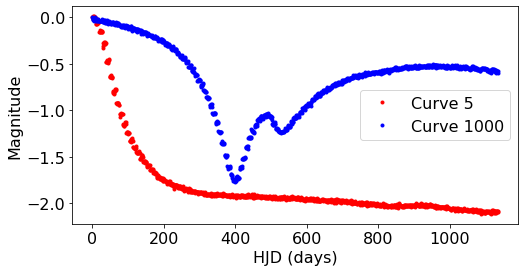

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
n = [5, 1000]
ax.plot(in_data[n[0], :], 'r.', label='Curve %i'%(n[0]))
ax.plot(in_data[n[1], :], 'b.', label='Curve %i'%(n[1]))
setLabels(ax, 'Magnitude', 'HJD (days)','')